In [92]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path)/"SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
        url,zip_path,extracted_path,data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return
    
    with urllib.request.urlopen(url) as response:
        with open(zip_path,"wb") as out_file:
            out_file.write(response.read())
    
    with zipfile.ZipFile(zip_path,"r") as zip_ref:
        zip_ref.extractall(extracted_path)
    
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path,data_file_path)
    print(f"File download and saved as {data_file_path}")

download_and_unzip_spam_data(url,zip_path,extracted_path,data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [93]:
import pandas as pd
df = pd.read_csv(
    data_file_path,sep="\t",header=None,names=["Label","Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [94]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [95]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam,random_state = 123
    )
    balanced_df = pd.concat([
        ham_subset,df[df["Label"] == "spam"]
    ])
    return balanced_df

In [96]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [97]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0,"spam":1})

In [98]:
def random_split(df,train_frac,validation_frac):
    df = df.sample(
        frac=1,random_state=123
    ).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df,validation_df,test_df

train_df,validation_df,test_df = random_split(
    balanced_df,0.7,0.1
)

In [99]:
train_df.to_csv("train.csv",index=None)
validation_df.to_csv("validation.csv",index=None)
test_df.to_csv("test.csv",index=None)

In [100]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


In [101]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self,csv_file,tokenizer,max_length=None,pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded,dtype=torch.long),
            torch.tensor(label,dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [102]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [103]:
print(train_dataset.max_length)

120


In [104]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [105]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [106]:
for input_batch,target_batch in train_loader:
    pass
print("Input batch dimensions:",input_batch.shape)
print("Label batch dimensions:",target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [107]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [108]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "drop_rate":0.0,
    "qkv_bias":True
}
model_configs = {
    "gpt2-small (124M)":{"emb_dim":768,"n_layers":12,"n_heads":12},
    "gpt2-medium (355M)":{"emb_dim":1024,"n_layers":24,"n_heads":16},
    "gpt2-large (774M)":{"emb_dim":1280,"n_layers":36,"n_heads":20},
    "gpt2-xl (1558M)":{"emb_dim":1600,"n_layers":48,"n_heads":25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [109]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b,num_tokens,self.num_heads,self.head_dim)
        queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)
        values = values.view(b,num_tokens,self.num_heads,self.head_dim)
        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)
        attn_scores = queries @ keys.transpose(2,3)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores.masked_fill_(mask_bool,-torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5,dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1,2)
        context_vec = context_vec.contiguous().view(b,num_tokens,self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            * [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"],cfg["vocab_size"],bias=False
        )
    def forward(self,in_idx):
        batch_size,seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self,x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))

class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
        )
    
    def forward(self,x):
        return self.layers(x)

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),
                          GELU())
        ])

    def forward(self,x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [110]:
import numpy as np

def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                         "Right: {right.shape}"
                         )
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [111]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings,params = download_and_load_gpt2(
    model_size=model_size,models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model,params)
model.eval()

Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models/124M/checkpoint) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [112]:
def generate_text_simple(model,idx,max_new_tokens,context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

            logits = logits[:,-1,:]
            probas = torch.softmax(logits,dim=-1)
            idx_next = torch.argmax(probas,dim=-1,keepdim=True)
            idx = torch.cat((idx,idx_next),dim=1)
    
    return idx

In [113]:
def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [114]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1,tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids,tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [115]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2,tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids,tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [116]:
for param in model.parameters():
    param.requires_grad = False

In [117]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

In [118]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [119]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:",inputs)
print("Inputs dimensions:",inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [120]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n",outputs)
print("Outputs dimensions:",outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [121]:
print("Last output token:",outputs[:,-1,:])

Last output token: tensor([[-3.5983,  3.9902]])


In [122]:
probas = torch.softmax(outputs[:,-1,:],dim=-1)
label = torch.argmax(probas)
print("Class label:",label.item())

Class label: 1


In [123]:
logits = outputs[:,-1,:]
label = torch.argmax(logits)
print("Class label:",label.item())

Class label: 1


In [124]:
def calc_accuracy_loader(data_loader,model,device,num_batches=None):
    model.eval()
    correct_predictions,num_examples = 0,0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:,-1,:]
            predicted_labels = torch.argmax(logits,dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    return correct_predictions / num_examples

In [125]:
device = torch.device("mps")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader,model,device,num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader,model,device,num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader,model,device,num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 57.50%
Validation accuracy: 61.25%
Test accuracy: 56.25%


In [126]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits,target_batch)
    return loss

In [127]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch,target_batch,model,device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [128]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device,num_batches=5)
    val_loss = calc_loss_loader(val_loader,model,device,num_batches=5)
    test_loss = calc_loss_loader(test_loader,model,device,num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.669
Validation loss: 0.717
Test loss: 0.710


In [129]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader,model,device,num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader,model,device,num_batches=eval_iter
        )
    model.train()
    return train_loss,val_loss

In [138]:
def train_classifier_simple(
        model,train_loader,val_loader,optimizer,device,
        num_epochs,eval_freq,eval_iter):
    train_losses,val_losses,train_accs,val_accs = [],[],[],[]
    examples_seen,global_step = 0,-1

    for epoch in range(num_epochs):
        model.train()
        for input_batch,target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch,target_batch,model,device
            )
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss,val_loss = evaluate_model(
                    model,train_loader,val_loader,device,eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, " 
                      f"Val loss {val_loss:.3f}")
        
        train_accuracy = calc_accuracy_loader(
            train_loader,model,device,num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader,model,device,num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ",end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses,val_losses,train_accs,val_accs,examples_seen

In [139]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5,weight_decay=0.1)
num_epochs = 5

train_losses,val_losses,train_accs,val_accs,example_seen = \
    train_classifier_simple(
        model,train_loader,val_loader,optimizer,device,
        num_epochs=num_epochs,eval_freq=50,
        eval_iter=5
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.295, Val loss 0.337
Ep 1 (Step 000050): Train loss 0.264, Val loss 0.335
Ep 1 (Step 000100): Train loss 0.299, Val loss 0.335
Training accuracy: 85.00% | Validation accuracy: 90.00%
Ep 2 (Step 000150): Train loss 0.407, Val loss 0.318
Ep 2 (Step 000200): Train loss 0.326, Val loss 0.314
Ep 2 (Step 000250): Train loss 0.330, Val loss 0.306
Training accuracy: 77.50% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.318, Val loss 0.300
Ep 3 (Step 000350): Train loss 0.320, Val loss 0.297
Training accuracy: 92.50% | Validation accuracy: 87.50%
Ep 4 (Step 000400): Train loss 0.176, Val loss 0.326
Ep 4 (Step 000450): Train loss 0.327, Val loss 0.289
Ep 4 (Step 000500): Train loss 0.303, Val loss 0.287
Training accuracy: 92.50% | Validation accuracy: 92.50%
Ep 5 (Step 000550): Train loss 0.319, Val loss 0.289
Ep 5 (Step 000600): Train loss 0.366, Val loss 0.277
Training accuracy: 95.00% | Validation accuracy: 92.50%
Training completed in 2.18 minu

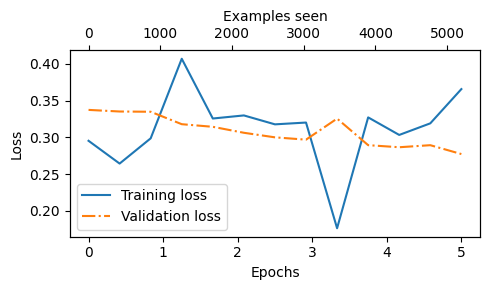

In [140]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen,examples_seen,train_values,val_values,
        label="loss"):
    fig ,ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen,train_values,label=f"Training {label}")
    ax1.plot(epochs_seen,val_values,linestyle="-.",
             label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen,train_values,alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
example_seen_tensor = torch.linspace(0,example_seen,len(train_losses))

plot_values(epochs_tensor,example_seen_tensor,train_losses,val_losses)

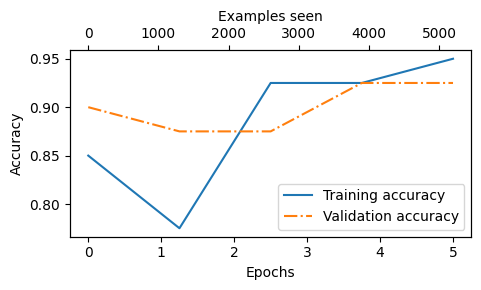

In [141]:
epochs_tensor = torch.linspace(0,num_epochs,len(train_accs))
example_seen_tensor = torch.linspace(0,example_seen,len(train_accs))

plot_values(epochs_tensor,example_seen_tensor,train_accs,val_accs,label="accuracy")

In [142]:
train_accuracy = calc_accuracy_loader(train_loader,model,device)
val_accuracy = calc_accuracy_loader(val_loader,model,device)
test_accuracy = calc_accuracy_loader(test_loader,model,device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 89.04%
Validation accuracy: 90.60%
Test accuracy: 88.67%


In [143]:
def classify_review(
        text,model,tokenizer,device,max_length=None,
        pad_token_id = 50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(max_length,supported_context_length)]

    input_ids += [pad_token_id] * (max_length-len(input_ids))

    input_tensor = torch.tensor(
        input_ids,device=device
    ).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:,-1,:]
    predicted_label = torch.argmax(logits,dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [144]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(text_1,model,tokenizer,device,max_length=train_dataset.max_length))

not spam


In [145]:
text_2 = (
    "Hey,just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(text_2,model,tokenizer,device,max_length=train_dataset.max_length))

not spam


In [146]:
torch.save(model.state_dict(),"review_classifier.pth")

In [147]:
model_state_dict = torch.load("review_classifier.pth",map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>